<h1> Laplacian Eigenmaps  </h1>  

n_component : INT    
n_neighbors : INT  
epsilon : FLOAT  
graph : ['k-nearest', 'dist']  
nn_connection : ['symmetric', 'mutual']  
weight : ['adjacency, 'heat_kernel', 'rbf']  
sigma : FLOAT

In [3]:
import numpy as np
import pandas as pd
import scipy
from sklearn.metrics import pairwise_distances
from sklearn import datasets
import matplotlib.pyplot as plt

In [21]:
class LE(object):
    def __init__(self, n_components:int, n_neighbors:int = 2, epsilon = None, graph:str = 'k-nearest', nn_connection:str = 'mutual', weight:str = 'heat_kernel', sigma:float = 5.):
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.nn_connection = nn_connection
        if graph not in ['k-nearest','dist']:
            raise ValueError('must choose k-nearst or dist')
        else:
            self.graph = graph
        if (self.graph == 'dist')&(epsilon == None):
            raise ValueError('epsilone must be set if you choose dist as graph method')
        else:
            self.epsilon = epsilon
        self.weight = weight
        self.sigma = sigma
            
    def fit_transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if X.shape[1] <= self.n_components:
            raise ValueError("n_components must be lower than original data's column numbers")
        
        #step1. construct graph G
        if self.graph == 'k-nearest':
            if self.nn_connection == 'symmetric':
                G = np.where(pairwise_distances(X).argsort(axis=0).argsort(axis=0) <= self.n_neighbors, 1., 0.) - np.eye(X.shape[0])
            if self.nn_connection == 'mutual':
                G = np.where(pairwise_distances(X).argsort(axis=0).argsort(axis=0) <= self.n_neighbors, 1., 0.) - np.eye(X.shape[0])
                G = np.where((G == G.T) & (G != 0), 1., 0.)
                
        if self.graph == 'dist':
            G = np.where(pairwise_distances(X) > self.eps, 1., 0.) - np.eye(X.shape[0])
            
        #step2. construct graph laplacian: L = D - W
        D = np.diag(G.sum(axis = 0))
        if self.weight == 'adjacency':
            W = G
        if self.weight == 'rbf':
            W = np.exp(-( (pairwise_distances(X)**2)  / (2*np.power(self.sigma,2))))
            W = np.where(G.astype('bool'), W, 0)
        if self.weight == 'heat_kernel':
            W = np.exp(-(pairwise_distances(X) / self.sigma))
            W = np.where(G.astype('bool'), W, 0)
        
        L = D - W
        
        #step3. Generalized eigenvalue problem L and sort eigenvalues ascendingly
        eigval, eigvec = scipy.linalg.eigh(L, D, eigvals_only = False)
#         eigval, eigvec = np.linalg.eig(L)
    
        idx = np.argsort(eigval)[1:self.n_components + 1]
        return np.row_stack([eigvec[:,i] for i in idx]).T
        

In [8]:
X, color = datasets.make_swiss_roll(random_state=42, n_samples = 500)

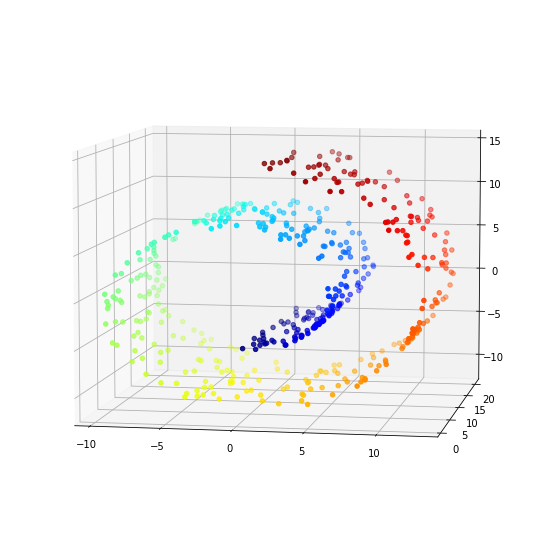

In [4]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(7, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.jet)

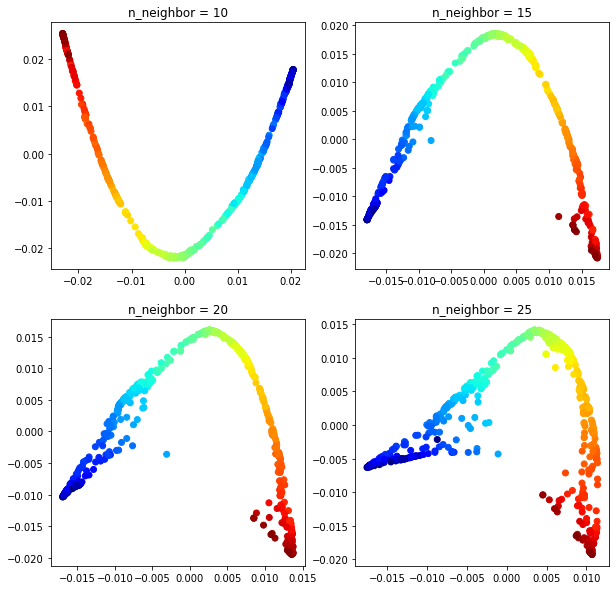

In [7]:
fig, ax = plt.subplots(2,2, figsize = (10,10))

i = 0
for n_n in [10,15,20,25]:
    le = LE(n_components=2, n_neighbors= n_n, weight='adjacency')
    red = le.fit_transform(X)
    ax[i//2,i%2].scatter(red[:,0], red[:,1], c = color, cmap = plt.cm.jet)
    ax[i//2,i%2].set_title(f'n_neighbor = {n_n}')
    i = i + 1

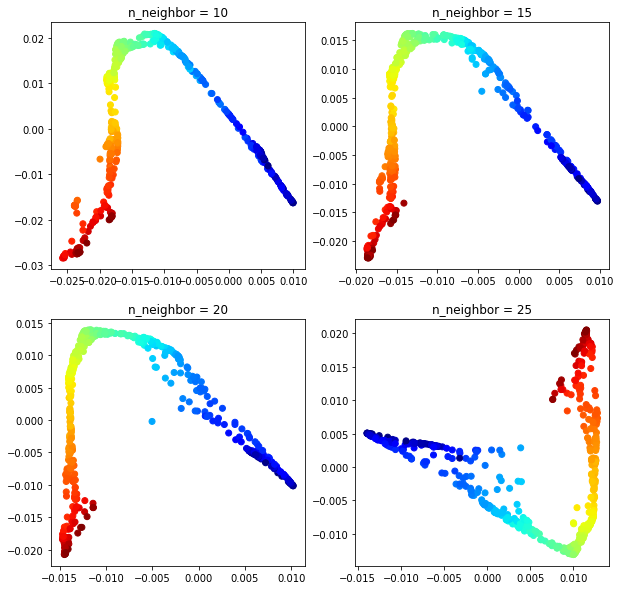

In [643]:
fig, ax = plt.subplots(2,2, figsize = (10,10))

i = 0
for n_n in [10,15,20,25]:
    le = LE(n_components=2, n_neighbors= n_n, weight='heat_kernel',sigma = 100)
    red = le.fit_transform(X)
    ax[i//2,i%2].scatter(red[:,0], red[:,1], c = color, cmap = plt.cm.jet)
    ax[i//2,i%2].set_title(f'n_neighbor = {n_n}')
    i = i + 1

n_neighbor가 작을때 값도 보고싶은데 일반화 고유값분해에서 에러가 엄청뜸 

In [4]:
X = np.random.normal(scale = 5, size = 15).reshape(5,3)
X

array([[12.60084759,  2.15718601, -4.46050816],
       [ 7.7542987 , -3.14330252, -6.29370318],
       [-9.65239936,  5.65380578,  1.54293376],
       [-5.2841043 , -2.34149988,  6.88183799],
       [-1.01020229, -2.16404278,  0.19843834]])

In [7]:
from sklearn.manifold import SpectralEmbedding